In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd 
import matplotlib.patches as mpatches

In [133]:
# Read data 
df = pd.read_csv('../data/province_systems.csv').rename(columns={'Province': 'name'})
df['Offsets_Allowed'] = df['Offsets_Allowed'].str.replace('Alternative Mechanism', 'N/A')

In [134]:
# Load Canada’s provinces (GeoJSON format)
url = "https://github.com/nvkelso/natural-earth-vector/raw/master/geojson/ne_50m_admin_1_states_provinces.geojson"
canada_provinces = gpd.read_file(url)
canada_provinces = canada_provinces[canada_provinces["admin"] == "Canada"]

In [137]:
canada_provinces = canada_provinces.merge(df)
color_map = {
    "Yes": "deepskyblue",
    "No": "salmon",
    "N/A": "darkgrey"
}

canada_provinces["color"] = canada_provinces["Offsets_Allowed"].map(color_map)

In [138]:
np.unique(canada_provinces['color'])

array(['darkgrey', 'deepskyblue', 'salmon'], dtype=object)

/var/folders/mv/mgldprdx6z7368f1tmc2gtnc0000gn/T/ipykernel_88583/2715443076.py:7: UserWarning:

Only specify one of 'column' or 'color'. Using 'color'.



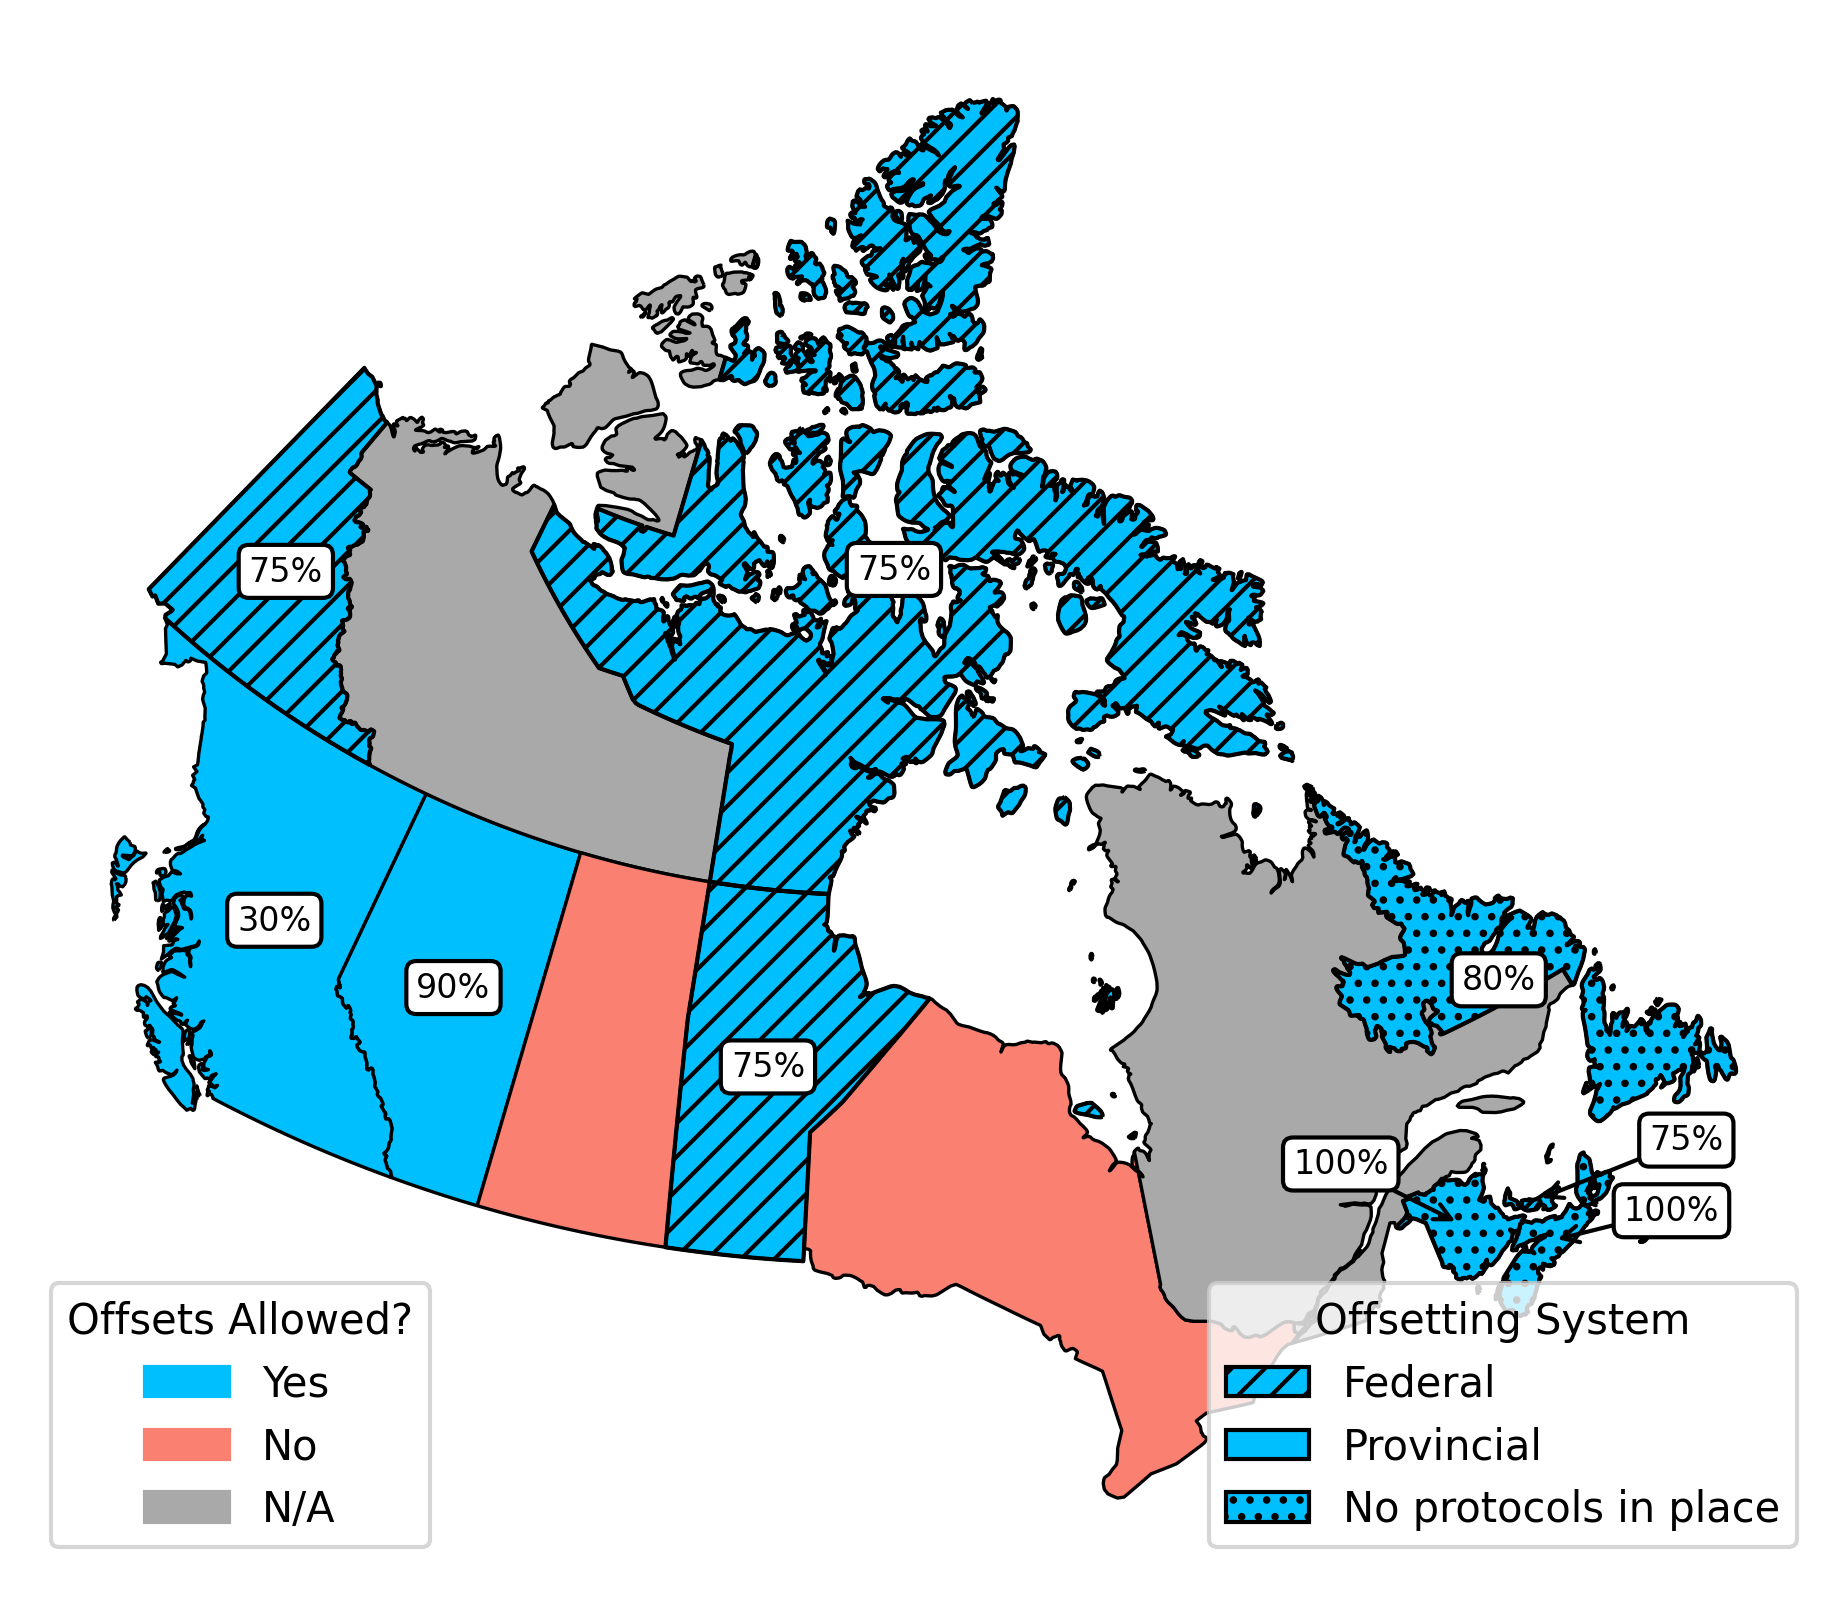

In [140]:
canada_provinces = canada_provinces.to_crs(epsg=3347)  # Canadian Lambert projection

# Create figure
fig, ax = plt.subplots(figsize=(9, 6), dpi = 300)

# Plot main choropleth map
canada_provinces.plot(
    column="Offsets_Allowed",
    color=canada_provinces["color"],    
    edgecolor="black",
    linewidth=0.8,
    legend=True,
    ax=ax
)

# Overlay hatch pattern for 'Federal' Offset_System
canada_provinces[canada_provinces["Offset_System"] == "Federal"].plot(
    ax=ax,
    facecolor="none",  # Keep it transparent
    edgecolor="black",
    hatch="///",  # Hatch pattern for hashing
    linewidth=1
)

canada_provinces[canada_provinces["Offset_System"] == "No protocols or process to apply"].plot(
    ax=ax,
    facecolor="none",  # Keep it transparent
    edgecolor="black",
    hatch="...",  # Hatch pattern for hashing
    linewidth=1
)

# Add text labels to center of each province
for idx, row in canada_provinces.iterrows():
    if np.isnan(row['Perc_Compliance_Obligation']):
        next
    else:
        # centroid = row.geometry.centroid
        # ax.text(
        #     centroid.x, centroid.y, f'{row["Perc_Compliance_Obligation"]}%', 
        #     fontsize=8, ha="center", va="center",
        #     color="black", bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3")
        # )
        centroid = row.geometry.centroid
        text_offset_x = 0
        text_offset_y = 0

        # Move the text box for specific provinces (e.g., Ontario, Quebec, British Columbia)
        if row["name"] == "New Brunswick":
            text_offset_x = -400000 
            text_offset_y = 200000  
        elif row["name"] == "Prince Edward Island":
            text_offset_x = 500000  
            text_offset_y = 200000 
        elif row["name"] == "Nova Scotia":
            text_offset_x = 400000 
            text_offset_y = 100000 

        # Add arrows for the small provinces 
        if row["name"] in ["New Brunswick", "Prince Edward Island", "Nova Scotia"]: 
            ax.annotate(
                "", 
                xy=(centroid.x, centroid.y), 
                xytext=(centroid.x + text_offset_x, centroid.y + text_offset_y),  # Adjust this for arrow position
                arrowprops=dict(facecolor="black", arrowstyle="->", lw=1)
            )
        
        # Add the text box at the offset position
        ax.text(
            centroid.x + text_offset_x, centroid.y + text_offset_y, f'{int(row["Perc_Compliance_Obligation"])}%', 
            fontsize=8, ha="center", va="center",
            color="black", bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3")
        )
        
    

# # Create custom legend for discrete colors
# legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
# ax.legend(handles=legend_patches, title="Offsets Allowed", loc="lower left")

# Create custom legend for discrete colors
color_legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]

# Create custom legend for hatch patterns
hatch_legend_patches = [
    mpatches.Patch(facecolor="deepskyblue", edgecolor="black", hatch="///", label="Federal"),
    mpatches.Patch(facecolor="deepskyblue", edgecolor="black", label="Provincial"),
    mpatches.Patch(facecolor="deepskyblue", edgecolor="black", hatch="...", label="No protocols in place") 
]



# Combine legends (all in one):
# legend_patches = color_legend_patches + hatch_legend_patches
# ax.legend(handles=legend_patches, title=None, loc="lower left")

# Separate legends:
# Add the color legend on the left
legend1 = ax.legend(handles=color_legend_patches, title='Offsets Allowed?', loc="lower left")
ax.legend(handles=hatch_legend_patches, title='Offsetting System', loc="lower right")
ax.add_artist(legend1)

## TODO: Add % label legend for data 

plt.tight_layout()

# Remove axis labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# Show plot
plt.show()